In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
df = pd.read_csv('./material/aCCF_0623_p_spec.csv')
df = df[df['Unnamed: 0'] % 2 == 0]
df['LATITUDE'] = df['LATITUDE'] * 111000
df['LONGITUDE'] = df['LONGITUDE'] * 85000
df = df.reset_index()
df = df.drop(columns=['index', 'Unnamed: 0'])
df

,LATITUDE,LONGITUDE,FL_hPa,TIME,MERGED,FL
0,3774000.0,-2550000.0,100,2018-06-23 06:00:00,0.113404,100
1,3774000.0,-2550000.0,100,2018-06-23 12:00:00,0.113514,100
2,3774000.0,-2550000.0,100,2018-06-23 18:00:00,0.113482,100
3,3774000.0,-2380000.0,100,2018-06-23 06:00:00,0.113423,100
4,3774000.0,-2380000.0,100,2018-06-23 12:00:00,0.113414,100
...,...,...,...,...,...,...
18223,6660000.0,2380000.0,600,2018-06-23 12:00:00,0.117499,360
18224,6660000.0,2380000.0,600,2018-06-23 18:00:00,0.117676,360
18225,6660000.0,2550000.0,600,2018-06-23 06:00:00,0.116333,360
18226,6660000.0,2550000.0,600,2018-06-23 12:00:00,0.118673,360


In [3]:
df_fuel = pd.read_csv('./material/bada_data.csv', delimiter='\t')
df_fuel = df_fuel[df_fuel['FL'] >= 100]
df_fuel['TAS-MS'] = df_fuel['TAS [kts]'] / 1.94384 # m/s
df_fuel = df_fuel.drop(columns=['TAS [kts]', 'TAS [kts].1', 'TAS [kts].2'])
df_fuel

,FL,fuel1,ROC [ft/min],fuel2,ROD [ft/min],fuel3,TAS-MS
9,100,40.3,2750,104.1,1680,8.4,148.674788
10,120,47.8,2670,99.4,2310,8.1,183.142645
11,140,47.6,2490,94.6,2340,7.9,188.287102
12,160,47.5,2310,89.8,2370,7.7,193.946004
13,180,47.3,2130,85.1,2400,7.5,199.604906
14,200,47.1,1940,80.5,2740,7.3,205.778253
15,220,46.9,1740,76.0,2760,7.1,211.951601
16,240,46.6,1550,71.6,2770,6.9,218.639394
17,260,46.4,1350,67.2,2780,6.7,225.327187
18,280,46.1,1150,62.9,2790,6.5,232.529426


In [20]:
time_grid = 120 # in seconds
total_time = []
uniques = {
    'LONGITUDE': df['LONGITUDE'].unique(),
    'LATITUDE': df['LATITUDE'].unique(),
    'FL': df['FL'].unique(),
    'TIME': [datetime.fromisoformat(x) for x in df['TIME'].unique()]
}
df_optimal = {(row['LONGITUDE'], row['LATITUDE'], row['FL'], datetime.fromisoformat(row['TIME'])): row['MERGED'] for [_, row] in df.iterrows()}

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def get_closest(target, column):
    res = min(uniques[column], key = lambda x: abs(x - target))
    return res

def lookup_climate(x,y,z, t):
    start = datetime.now()
    #test = df[
    #    (df['LATITUDE'] == get_closest(x, 'LATITUDE')) & 
    #    (df['LONGITUDE'] == get_closest(y, 'LONGITUDE')) & 
    #    (df['FL'] == get_closest(z, 'FL')) & (df['TIME'] == get_closest(t, 'TIME'))
    #]['MERGED'].values[0]
    test = df_optimal[(get_closest(x, 'LONGITUDE'), get_closest(y, 'LATITUDE'), get_closest(z, 'FL'), get_closest(t, 'TIME'))]
    end = datetime.now()
    total_time.append(end - start)
    return test
    
def turn_radius(v):
    return v**2 / (9.81 * np.tan(2 / 180 * np.pi))

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy
    

def point_on_circle(x,y,v, direction):
    
    r = turn_radius(v)
    [a, b] = [x, y + (-1 if direction == 'right' else 1) * r]
    d = v * time_grid
    t = d / r
    
    if t > np.pi / 2:
        warnings.warn('The airplane will make more than a 90° turn')
    
    # sin and cos swapped because we have y+ as a base
    return [
        a + r * np.sin(t),
        b - r * np.cos(t) * (-1 if direction == 'right' else 1),
        t
    ]

    
def lookup_path(x, y, z, t, alpha, path):
    row = df_fuel[df_fuel['FL'] == get_closest(z, 'FL')]
    v = row['TAS-MS'].values[0]
    if path == 'up':
        z_change = row['ROC [ft/min]'].values[0] / 60 * time_grid
        z_new = z + z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel2'].values[0]
        y_new = y
        new_alpha = alpha
    elif path == 'down':
        z_change = row['ROD [ft/min]'].values[0] / 60 * time_grid
        z_new = z - z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel3'].values[0]
        y_new = y
        new_alpha = alpha
    elif path == 'straight':
        z_new = z
        fuel = row['fuel1'].values[0]
        x_new = x + time_grid * v
        y_new = y
        new_alpha = alpha
    elif path == 'left':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'left')
        z_new = z
        fuel = row['fuel1'].values[0]
        new_alpha = alpha - delta_alpha
    elif path == 'right':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'right')
        z_new = z
        fuel = row['fuel1'].values[0]
        new_alpha = alpha + delta_alpha
        
    new_alpha = new_alpha % (2 * np.pi)
    
    # rotate new coordinates
    [x_new, y_new] = rotate([x,y], [x_new, y_new], new_alpha)

    return {
        'coordinates': [x_new, y_new, z_new],
        'cost': lookup_climate(x_new, y_new, z_new, t + timedelta(seconds=time_grid)) * fuel,
        'time': t + timedelta(seconds=time_grid),
        'alpha': new_alpha
    }
    
step_max = 20
def look_ahead(step, x, y, z, t, alpha):
    
    new_options = lookup_options(x,y,z,t, alpha)
    
    possible_directions = [x for x in new_options.keys() if x not in ['total_path_cost', 'next']]
    if step > 0:
        possible_directions = ['straight']
    
    new_options['total_path_cost'] = 0

    for d in possible_directions:
        new_options[d]['total_path_cost'] = 0
        [x_new, y_new, z_new] = new_options[d]['coordinates']
        t_new = new_options[d]['time']
        a_new = new_options[d]['alpha']
        new_options[d]['total_path_cost'] += new_options[d]['cost']
        if step < step_max:
            new_new_options = look_ahead(step + 1, x_new, y_new, z_new, t_new, a_new)
            new_options[d]['total_path_cost'] += sum([v['total_path_cost'] for k,v in new_new_options.items() if k != 'total_path_cost' ])

    return {k:v for k,v in new_options.items() if k in possible_directions or k in ['total_path_cost']}
    
def lookup_options(x, y, z, t, alpha):

    
    final_object = {
        'straight' : lookup_path(x,y,z,t, alpha, 'straight'),
        'left' : lookup_path(x,y,z,t, alpha, 'left'),
        'right' : lookup_path(x,y,z,t, alpha, 'right'),
    }
    
    if(z > 100):
        final_object['down'] = lookup_path(x,y,z,t, alpha, 'down')
        
    if(z < 400):
        final_object['up'] = lookup_path(x,y,z,t, alpha, 'up')
    
    return final_object


In [21]:
total = 0
start = datetime.now()
test = look_ahead(0, -2518786.6963108564, 6254166.515710507 , 200, datetime(2018, 6, 23, 6, 1, 0), np.pi / 4.0)
end = datetime.now()
print(end - start)
print(sum(total_time, timedelta()))
test

0:00:00.262725
0:00:00.031101


{'straight': {'coordinates': [-2501325.83250676, 6271627.379514603, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.7853981633974483,
  'total_path_cost': 8.453939847413952},
 'left': {'coordinates': [-2499703.4384556036, 6269773.167555079, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.5856261798393554,
  'total_path_cost': 33.944945314927075},
 'right': {'coordinates': [-2503180.0444662846, 6273249.77356576, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.9851701469555412,
  'total_path_cost': -3.476866315745858},
 'down': {'coordinates': [-2501761.228188505, 6271191.983832858, 145.2],
  'cost': 0.7157469706188042,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.7853981633974483,
  'total_path_cost': 93.59370903031795},
 'up': {'coordinates': [-2501542.7244718284, 6271410.487549535, 238.8],
  'cost': 6.6539453904356956,
  'time'

In [16]:
flights = pd.read_csv('./material/flights.csv', delimiter=';')
flights['start_time'] = pd.to_datetime('2018-06-23 '+ flights['start_time'])
flights['start_latitudinal'] = flights['start_latitudinal'] * 111000
flights['end_latitudinal'] = flights['end_latitudinal'] * 111000
flights['start_longitudinal'] = flights['start_longitudinal'] * 85000
flights['end_longitudinal'] = flights['end_longitudinal'] * 85000
flights

,flight_number,start_time,start_flightlevel,start_longitudinal,start_latitudinal,end_longitudinal,end_latitudinal
0,0,2018-06-23 07:15:00,250,-2550000,6216000,2040000,6660000
1,1,2018-06-23 07:10:00,310,-2550000,6216000,2550000,4662000
2,2,2018-06-23 07:50:00,250,-1870000,3774000,2550000,5106000
3,3,2018-06-23 07:30:00,260,-2210000,3774000,2380000,6660000
4,4,2018-06-23 07:00:00,230,-2550000,4662000,2550000,5106000
...,...,...,...,...,...,...,...
95,95,2018-06-23 06:10:00,260,-2550000,4440000,2210000,6660000
96,96,2018-06-23 07:05:00,200,-2550000,4662000,1870000,6660000
97,97,2018-06-23 06:00:00,300,-1190000,3774000,2550000,5772000
98,98,2018-06-23 07:30:00,310,-2550000,4440000,2550000,6216000


In [29]:
final_position = False

flight = flights.iloc[0]
# flight['start_latitudinal'] = 4816000
x = flight['start_longitudinal']
y = flight['start_latitudinal']
z = flight['start_flightlevel']
t = flight['start_time']
alpha = np.random.random() * 2*np.pi
history = [{
    'coordinates': [x,y,z],
    'time': t,
    'cost': 0,
    'alpha': alpha
}]
history_options = []

def is_close(p1, p2):
    return get_distance(p1, p2) < 5000

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

flight['end_latitudinal'] = 6660000
# while not final_position:
options = lookup_options(x, y, z, t, alpha)
for k in options.keys():
    options[k]['target_distance'] = get_distance(
        options[k]['coordinates'], 
        [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]
    )
    options[k]['total_cost'] = options[k]['cost'] +  options[k]['target_distance'] * 0.01
    options[k]['direction'] = k

next_step = min(options.values(), key = lambda x: x['total_cost'])
[ x, y, z ] = next_step['coordinates']
alpha = next_step['alpha']
t = next_step['time']
history.append(next_step)
history_options.append(options)
if len(history) % 50 == 0:
    print(next_step)

if is_close(history[-1]['coordinates'], [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]):
    print("FINSIHED")
    #break
# while agent not in target
# get all options for current state
# pick best option or random option wi'th x chance
# move there
# record history

# finally record path and total cost

/tmp/ipykernel_9900/2017482209.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight['end_latitudinal'] = 6660000


In [30]:
next_direction = 'down'
direction = 'down'

In [31]:
direction = next_direction
total_distance = get_distance(
    [flight['start_longitudinal'], flight['start_latitudinal'], flight['start_flightlevel']],  
    [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]
)
while True:# next_direction == direction:
    step_max = round(
        (get_distance([x,y,z],  [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]) / total_distance)
        * 20
    ) + 1
    print(step_max)
    options = look_ahead(0, x, y, z, t, alpha)
    possible_directions = [x for x in options.keys() if x not in ['total_path_cost', 'next']]
    for k in possible_directions:
        options[k]['target_distance'] = get_distance(
            options[k]['coordinates'], 
            [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]
        )
        options[k]['total_cost'] =  options[k]['total_path_cost'] +  options[k]['target_distance'] * 0.0001
        options[k]['direction'] = k

    options.pop('total_path_cost', None)
    next_step = min(options.values(), key = lambda x: x['total_cost'])
    [ x, y, z ] = next_step['coordinates']
    alpha = next_step['alpha']
    t = next_step['time']
    direction = next_direction
    next_direction = next_step['direction']
    # print([next_direction, next_step['total_cost']])
    history.append(next_step)
    history_options.append(options)
    if len(history_options) % 100:
        print([(history_options[-1][k]['direction'], round(history_options[-1][k]['total_path_cost'])) for k in history_options[-1].keys()], next_direction)

    if is_close(history[-1]['coordinates'], [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]):
        print("FINSIHED")
        break

21
[('straight', 85), ('left', 85), ('right', 85), ('down', 122), ('up', 98)] right
21
[('straight', 85), ('left', 85), ('right', 85), ('down', 119), ('up', 98)] right
21
[('straight', 85), ('left', 85), ('right', 85), ('down', 108), ('up', 98)] right
21
[('straight', 85), ('left', 85), ('right', 85), ('down', 83), ('up', 98)] down
21
[('straight', 87), ('left', 107), ('right', 114), ('down', 100), ('up', 88)] straight
20
[('straight', 83), ('left', 104), ('right', 110), ('down', 96), ('up', 84)] straight
20
[('straight', 84), ('left', 99), ('right', 117), ('down', 96), ('up', 84)] up
20
[('straight', 81), ('left', 81), ('right', 81), ('down', 147), ('up', 87)] right
20
[('straight', 81), ('left', 81), ('right', 81), ('down', 133), ('up', 87)] left
20
[('straight', 81), ('left', 81), ('right', 81), ('down', 162), ('up', 87)] right
20
[('straight', 81), ('left', 81), ('right', 81), ('down', 148), ('up', 87)] left
20
[('straight', 81), ('left', 81), ('right', 81), ('down', 159), ('up', 8

In [ ]:
path = np.array([[d[x]['total_cost'] for x in d.keys()] for d in history_options])
for i,k in enumerate(history_options[0].keys()):
    plt.plot(path[:, i], label=k)

plt.xlim(0,2)
plt.ylim(46075,46140)
plt.legend()

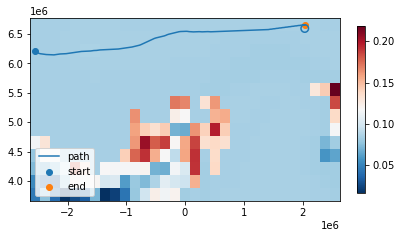

In [32]:
import matplotlib.pyplot as plt

path = np.array([x['coordinates'][0:2] for x in history])
image = df[df['FL'] == 200].pivot_table(columns='LONGITUDE', index = 'LATITUDE', values='MERGED')
plt.imshow(image, extent =[-31 * 85000, 31 * 85000, 33 * 111000, 61 * 111000], cmap = 'RdBu_r')

plt.colorbar(fraction=0.02503)
plt.plot(path[:, 0], path[:, 1], label='path')
plt.scatter(flight['start_longitudinal'], flight['start_latitudinal'], label='start')
plt.scatter(flight['end_longitudinal'], flight['end_latitudinal'], label='end')

#plt.xlim([6214000, 6230000])
#plt.ylim([-2550000, -2530000])
plt.legend()
plt.show()

{'straight': {'coordinates': [2039300.223487382,
   6662319.687861432,
   89.39999999999999],
  'cost': 4.164371334713933,
  'time': Timestamp('2018-06-23 14:47:00'),
  'alpha': 0.23897658684281087,
  'total_path_cost': 8.328742669427866,
  'target_distance': 2428.256844340851,
  'total_cost': 8.57156835386195,
  'direction': 'straight'},
 'left': {'coordinates': [2039660.3314579204,
   6659884.883711186,
   89.39999999999999],
  'cost': 4.164371334713933,
  'time': Timestamp('2018-06-23 14:47:00'),
  'alpha': 6.245660878717079,
  'total_path_cost': 8.328742669427866,
  'target_distance': 392.961624626061,
  'total_cost': 8.368038831890471,
  'direction': 'left'},
 'right': {'coordinates': [2038500.058072788,
   6664647.279816605,
   89.39999999999999],
  'cost': 4.164371334713933,
  'time': Timestamp('2018-06-23 14:47:00'),
  'alpha': 0.5154776021481298,
  'total_path_cost': 8.328742669427866,
  'target_distance': 4885.98279150001,
  'total_cost': 8.817340948577867,
  'direction': 'ri

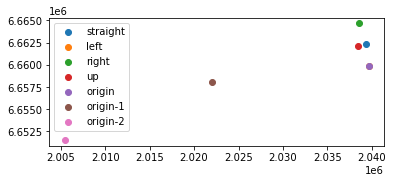

In [33]:
for k in options.keys():
    plt.scatter(options[k]['coordinates'][0], options[k]['coordinates'][1], label=k)

plt.scatter(history[-1]['coordinates'][0], history[-1]['coordinates'][1], label='origin')
plt.scatter(history[-2]['coordinates'][0], history[-2]['coordinates'][1], label='origin-1')
plt.scatter(history[-3]['coordinates'][0], history[-3]['coordinates'][1], label='origin-2')

[x_r, y_r] = rotate(
    [history[-2]['coordinates'][0], history[-2]['coordinates'][1]],
    [history[-1]['coordinates'][0], history[-1]['coordinates'][1]],
    np.pi / 2
)
#plt.scatter(x_r, y_r, label='r')
#plt.xlim([6214000, 6230000])
#plt.ylim([-2550000, -2530000])

plt.axis('scaled')
plt.legend()
history_options[-1]

In [ ]:
a = np.array([x['alpha'] for x in history])
plt.plot(a)

In [ ]:
c = np.array([x['total_cost'] for x in history])
plt.plot(c)

89.39999999999999

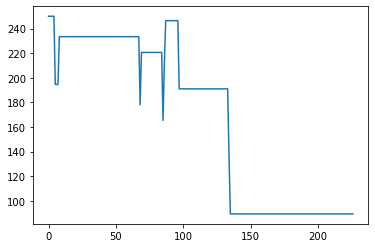

In [34]:
z_level = np.array([h['coordinates'][2] for h in history])
plt.plot(z_level)
min(z_level)

In [ ]:
d = np.array([x['target_distance'] for x in history[1:]])
plt.plot(d)

In [ ]:
rotate([0,0], [1, 0], np.pi / -4)

In [251]:
flight

flight_number                           0
start_time            2018-06-23 07:15:00
start_flightlevel                     250
start_longitudinal               -2550000
start_latitudinal                 6216000
end_longitudinal                  2040000
end_latitudinal                   6660000
Name: 0, dtype: object